To make it a bit more realistic, here's a potential scenario for our study:

- Let's imagine you work on the product team at a medium-sized online e-commerce business. The UX designer worked really hard on a new version of the product page, with the hope that it will lead to a higher conversion rate. The product manager (PM) told you that the current conversion rate is about 13% on average throughout the year, and that the team would be happy with an increase of 2%, meaning that the new design will be considered a success if it raises the conversion rate to 15%.


# Designing Experiment

### Choosing the variables
- A control group - Shown in the old design
- A treatment (or experimental) group - They'll be shown in the new design

For our Dependent Variable (i.e. what we are trying to measure), we are interested in capturing the conversion rate. A way we can code this is by each user session with a binary variable:

0 - The user did not buy the product during this user session
1 - The user bought the product during this user session

To easily calculate the mean for each group to get the conversion rate of each design.

### Choosing a sample size

It is important to note that since we won't test the whole user base (our population), the conversion rates that we'll get will inevitably be only estimates of the true rates.

The number of people (or user sessions) we decide to capture in each group will have an effect on the precision of our estimated conversion rates: the larger the sample size, the more precise our estimates (i.e. the smaller our confidence intervals), the higher the chance to detect a difference in the two groups, if present.

On the other hand, the larger our sample gets, the more expensive (and impractical) our study becomes.

So how many people should we have in each group?

The sample size we need is estimated through something called Power analysis, and it depends on a few factors:

- Power of the test  - This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 as a convention 
- Alpha value  - The critical value we set earlier to 0.05
- Effect size - How big of a difference we expect there to be between the conversion rates

Since our team would be happy with a difference of 2%, we can use 13% and 15% to calculate the effect size we expect.

In [25]:
# Importing packages
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline


In [12]:
# Calculation of effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.13, 0.15)

# Calculating sample size needed
req_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  
# Rounding up to next whole number 
req_n = ceil(req_n)                                                   

print(req_n)


4720


We'd need at least *4720* observations for each group.
- Having set the power parameter to 0.8 in practice means that if there exists an actual difference in conversion rate between our designs, assuming the difference is the one we estimated (13% vs. 15%), we have about 80% chance to detect it as statistically significant in our test with the sample size we calculated.

# Data Preparing and Collecting

In [13]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [15]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


We'll actually only use the group and converted columns for the analysis.

let's make sure there are no users that have been sampled multiple times.

In [16]:
session_counts = df['user_id'].value_counts(ascending = False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [17]:
# Removing the users appearing twice
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


## Sampling

In [18]:
control_sample = df[df['group'] == 'control'].sample(n=req_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=req_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [19]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [20]:
ab_test['group'].value_counts()

group
control      4720
treatment    4720
Name: count, dtype: int64

# Visualization

In [22]:
conversion_rates = ab_test.groupby('group')['converted']

#Standard Deviation of proportion 
std_p = lambda x: np.std(x, ddof=0)
#Standard error of proportion (std/sqrt(n))
se_p = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

/var/folders/mb/br6q_fb178v9vzc80nb09sy80000gn/T/ipykernel_27741/3116114913.py:8: FutureWarning: The provided callable <function mean at 0x108140900> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])


,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


From above calculation it looks like our two designs performed very similarly, with new design performing slightly better, approx. 12.3% vs. 12.6% conversion rate.

/var/folders/mb/br6q_fb178v9vzc80nb09sy80000gn/T/ipykernel_27741/1350423101.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False, palette={'control': 'blue', 'treatment': 'green'})
/var/folders/mb/br6q_fb178v9vzc80nb09sy80000gn/T/ipykernel_27741/1350423101.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False, palette={'control': 'blue', 'treatment': 'green'})


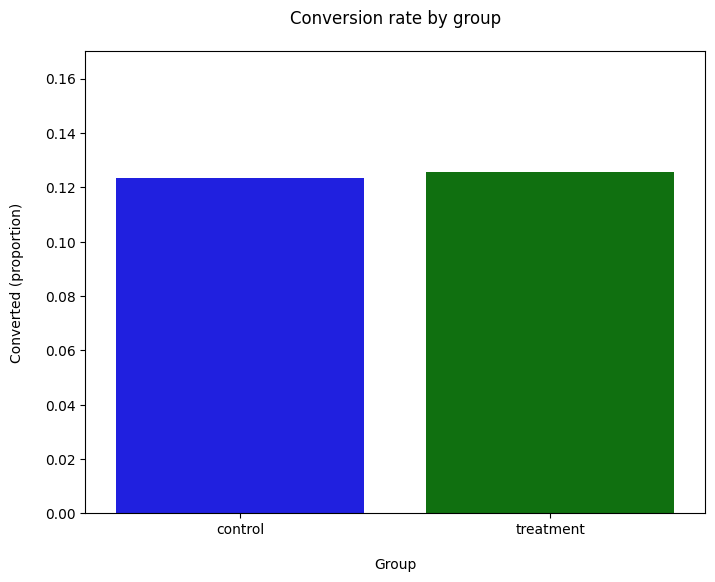

In [27]:
# Plotting the data
plt.figure(figsize=(8, 6))

# Create a bar plot with different colors for control and treatment
sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False, palette={'control': 'blue', 'treatment': 'green'})

# Customize the plot
plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)

# Show the plot
plt.show()

The conversion rates for groups are indeed very close. Also the conversion rate of the control group is lower than expected given about avg. conversion rate (12.3% vs. 13%). This shows that there is some variation in results when sampling from a population.

# Hypothesis Testing